In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import precision_score, confusion_matrix, make_scorer

In [2]:
training_labels = pd.read_csv('../Data/training_set_labels.csv')
training_values = pd.read_csv('../Data/training_set_values.csv')
test_values = pd.read_csv('../Data/test_set_values.csv')

In [3]:
training_labels['status_group'] = training_labels['status_group'].map({'non functional': 'non operational', 'functional': 'operational', 
                                     'functional needs repair': 'operational'})

In [4]:
df = training_values.merge(training_labels, on='id')

In [5]:
df['status_group']

0            operational
1            operational
2            operational
3        non operational
4            operational
              ...       
59395        operational
59396        operational
59397        operational
59398        operational
59399        operational
Name: status_group, Length: 59400, dtype: object

In [6]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [7]:
df.drop("id", axis = 1,inplace=True)

In [8]:
def full_value_counts(df):
    for column in df.columns:
        print(column)
        print(df[column].value_counts())
        print()

In [9]:
full_value_counts(df)

amount_tsh
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

date_recorded
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2002-10-14      1
2004-06-01      1
2004-04-05      1
2011-09-26      1
2011-09-20      1
Name: date_recorded, Length: 356, dtype: int64

funder
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Esawa                        1
Halimashauli                 1
Kiwanda Cha Ngozi            1
Ncs                          1
Tgrs                         1
Name: funder, Length: 1897, dtype: int64

gps_height
 0       20438
-15         60
-16         55
-13         55
-20         52
         ..

In [10]:
columns_to_drop = ["amount_tsh", "num_private", "recorded_by", "payment_type", "extraction_type", "extraction_type_group", 
                   "water_quality", "quantity_group", "scheme_name"]
df_small = df.drop(columns_to_drop, axis = 1)

In [11]:
df_small_small = df_small.replace({'none': None,'unknown' : None, -2.00E-08: None, "0": None})
df_small_small["district_code"].replace({0: None}, inplace=True)
df_small_small["population"].replace({0: None}, inplace=True)
df_small_small["construction_year"].replace({0: None}, inplace=True)

In [12]:
for column in df_small_small.columns:
    print(column + ' : ', len(df_small_small[column].unique()))

date_recorded :  356
funder :  1898
gps_height :  2428
installer :  2145
longitude :  57516
latitude :  57517
wpt_name :  37400
basin :  9
subvillage :  19288
region :  21
region_code :  27
district_code :  20
lga :  125
ward :  2092
population :  1049
public_meeting :  3
scheme_management :  13
permit :  3
construction_year :  55
extraction_type_class :  7
management :  12
management_group :  5
payment :  7
quality_group :  6
quantity :  5
source :  10
source_type :  7
source_class :  3
waterpoint_type :  7
waterpoint_type_group :  6
status_group :  2


In [13]:
funder :  1859
gps_height :  2428
installer :  2113
longitude :  57515
latitude :  57516
wpt_name :  36720
basin :  9
subvillage :  18568

In [14]:
df_small_small.dropna(subset=['latitude'],inplace=True)

In [15]:
index_test = df_small_small['installer'].value_counts().reset_index().drop('installer', axis = 1).to_dict()['index']

In [16]:
def transform_columns(dataframe, columns):
    transformed_df = pd.DataFrame()
    key = {}
    for column in columns:
        unique_vals = dataframe[column].value_counts().index
        key[column] = dataframe[column].value_counts().reset_index().drop(column, axis = 1).to_dict()['index']
        string_to_numbers = dataframe[column].replace(to_replace=unique_vals, value=list(range(len(unique_vals))))
        transformed_df[column] = string_to_numbers
        
    return transformed_df, key

In [17]:
def revert_back_to_strings(df, key):
    for column in df.columns:
        if column not in ['date_recorded', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year'] :
            df[column].replace(key[column], inplace = True)
    
    return df

In [18]:
# transformed_df, key = transform_columns(df_small_small, ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 
#                                                      'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 
#                                                      'scheme_management', 'permit', 'extraction_type_class',
#                                                      'management', 'management_group', 'payment', 'quality_group', 
#                                                      'quantity', 'source', 'source_type', 'source_class','waterpoint_type',
#                                                      'waterpoint_type_group', 'status_group'])

In [19]:
# transformed_df['date_recorded'] = df_small_small['date_recorded']
# transformed_df['gps_height'] = df_small_small['gps_height']
# transformed_df['longitude'] = df_small_small['longitude']
# transformed_df['latitude'] = df_small_small['latitude']
# transformed_df['population'] = df_small_small['population']
# transformed_df['construction_year'] = df_small_small['construction_year']

In [20]:
# transformed_df.to_csv('transformed_df.csv')

In [21]:
transformed_df = pd.read_csv('transformed_df.csv', index_col=0)
transformed_df.columns

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'public_meeting',
       'scheme_management', 'permit', 'extraction_type_class', 'management',
       'management_group', 'payment', 'quality_group', 'quantity', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'date_recorded', 'gps_height',
       'longitude', 'latitude', 'population', 'construction_year'],
      dtype='object')

In [22]:
X = transformed_df.drop('status_group', axis=1)
y = transformed_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.3)

In [23]:
# imputed_df.rename(columns={'0': 'funder', '1': 'installer', '2': 'wpt_name', '3': 'basin', '4': 'subvillage',
#                                    '5': 'region', '6': 'region_code', '7': 'district_code', '8': 'lga', '9': 'ward',
#                                    '10': 'public_meeting', '11': 'scheme_management', '12': 'scheme_name', '13': 'permit',
#                                    '14': 'extraction_type_class', '15': 'management', '16': 'management_group', '17': 
#                                    'payment', '18': 'quality_group', '19': 'quantity', '20': 'source', '21': 'source_type',
#                                    '22': 'source_class', '23': 'waterpoint_type', '24': 'waterpoint_type_group', '25': 
#                                    'date_recorded', '26': 'gps_height', '27': 'longitude', '28': 'latitude', '29': 'population',
#                                    '30': 'construction_year'}, inplace=True)

In [24]:
# df = revert_back_to_strings(imputed_df[['date_recorded']], key)

In [25]:
X_train_imputed = pd.read_csv('X_train_imputed.csv', index_col=0)
X_test_imputed = pd.read_csv('X_test_imputed.csv', index_col=0)

In [26]:
X_imputed = pd.concat([X_train_imputed, X_test_imputed])
X_imputed 

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,16.0,159.0,10914.0,5.0,25.0,12.0,11.0,4.0,68.0,331.0,...,2.0,0.0,2.0,0.0,2011.0,0.0,35.891855,-6.153545,330.952508,1998.387233
1,12.0,2.0,22561.0,4.0,16380.0,7.0,7.0,0.0,12.0,66.0,...,0.0,0.0,0.0,0.0,2013.0,1260.0,30.914468,-3.326810,530.000000,1993.000000
2,12.0,50.0,4266.0,8.0,8951.0,16.0,15.0,3.0,103.0,1003.0,...,3.0,1.0,0.0,0.0,2013.0,2137.0,31.631254,-7.863417,750.000000,1984.000000
3,1.0,4.0,7719.0,6.0,16557.0,8.0,8.0,2.0,18.0,421.0,...,0.0,0.0,0.0,0.0,2013.0,462.0,34.831606,-11.319762,96.000000,1992.000000
4,0.0,0.0,26690.0,2.0,6903.0,3.0,3.0,3.0,27.0,473.0,...,1.0,0.0,1.0,1.0,2011.0,295.0,36.624641,-8.410004,400.000000,1976.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17272,1.0,0.0,21782.0,6.0,86.0,8.0,8.0,1.0,23.0,384.0,...,1.0,0.0,1.0,1.0,2013.0,981.0,35.662256,-10.363942,800.000000,1990.000000
17273,689.0,2037.0,17723.0,2.0,1730.0,3.0,3.0,0.0,4.0,95.0,...,3.0,1.0,0.0,0.0,2011.0,310.0,36.994441,-7.595949,150.000000,2008.000000
17274,63.0,506.0,1.0,5.0,2572.0,3.0,3.0,5.0,25.0,25.0,...,2.0,0.0,0.0,0.0,2011.0,394.0,37.442462,-6.301995,1.000000,2009.000000
17275,8.0,11.0,16592.0,0.0,3389.0,2.0,2.0,1.0,43.0,59.0,...,0.0,0.0,0.0,0.0,2013.0,917.0,37.597108,-3.701546,67.000000,2013.000000


# Decision Tree Model

In [27]:
X_train_imputed

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,16.0,159.0,10914.0,5.0,25.0,12.0,11.0,4.0,68.0,331.0,...,2.0,0.0,2.0,0.0,2011.0,0.0,35.891855,-6.153545,330.952508,1998.387233
1,12.0,2.0,22561.0,4.0,16380.0,7.0,7.0,0.0,12.0,66.0,...,0.0,0.0,0.0,0.0,2013.0,1260.0,30.914468,-3.326810,530.000000,1993.000000
2,12.0,50.0,4266.0,8.0,8951.0,16.0,15.0,3.0,103.0,1003.0,...,3.0,1.0,0.0,0.0,2013.0,2137.0,31.631254,-7.863417,750.000000,1984.000000
3,1.0,4.0,7719.0,6.0,16557.0,8.0,8.0,2.0,18.0,421.0,...,0.0,0.0,0.0,0.0,2013.0,462.0,34.831606,-11.319762,96.000000,1992.000000
4,0.0,0.0,26690.0,2.0,6903.0,3.0,3.0,3.0,27.0,473.0,...,1.0,0.0,1.0,1.0,2011.0,295.0,36.624641,-8.410004,400.000000,1976.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40306,1198.0,0.0,14653.0,0.0,157.0,10.0,9.0,4.0,80.0,819.0,...,2.0,0.0,0.0,0.0,2011.0,52.0,38.973581,-5.375739,12.000000,1995.000000
40307,28.0,59.0,2.0,0.0,8.0,2.0,2.0,2.0,11.0,518.0,...,3.0,1.0,0.0,0.0,2013.0,500.0,38.078320,-4.480761,140.000000,2013.000000
40308,395.0,2.0,26850.0,5.0,2428.0,3.0,3.0,5.0,25.0,539.0,...,3.0,1.0,0.0,0.0,2011.0,520.0,37.560400,-6.917776,1.000000,1985.000000
40309,1.0,4.0,28238.0,2.0,210.0,8.0,8.0,4.0,21.0,673.0,...,3.0,1.0,2.0,0.0,2013.0,844.0,36.122400,-10.463274,250.000000,1982.000000


In [28]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_imputed, y_train)

DecisionTreeClassifier(random_state=42)

In [29]:
tree.predict(X_test_imputed)

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [31]:
#untuned score
precision_score(y_test, tree.predict(X_test_imputed))

0.7240023303233324

In [33]:
scorer  = make_scorer(precision_score, pos_label=0)

In [34]:
# hyperparameters to search over
parameters = {'max_depth': [36, 38, 40, 42, 44], 'min_samples_split': [2, 4, 6, 8], 'min_samples_leaf': [1, 2, 3, 4]}

# cross-validate to tune parameters
search = GridSearchCV(tree, parameters, cv=5, scoring = scorer)
search.fit(X_train_imputed, y_train)

#best parameters and associated score 
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

Best hyperparameters: {'max_depth': 44, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.8311530867209406


In [35]:
#Tree with tuned parameters
tuned_tree = DecisionTreeClassifier(random_state=42, min_samples_leaf = 1, min_samples_split = 6)
tuned_tree.fit(X_train_imputed, y_train)

DecisionTreeClassifier(min_samples_split=6, random_state=42)

In [36]:
tuned_tree.get_depth()

47

In [ ]:
scores = cross_val_score(tuned_tree, X_train_imputed, y_train, cv=5, scoring = scorer)
scores

In [ ]:
precision_score(y_train, tuned_tree.predict(X_train_imputed), pos_label=0)

In [ ]:
precision_score(y_test, tuned_tree.predict(X_test_imputed), pos_label=0)

In [ ]:
X_train_imputed.shape

In [ ]:
X_test_imputed.shape

In [ ]:
confusion_matrix(y_test, tuned_tree.predict(X_test_imputed),labels = [1,0])

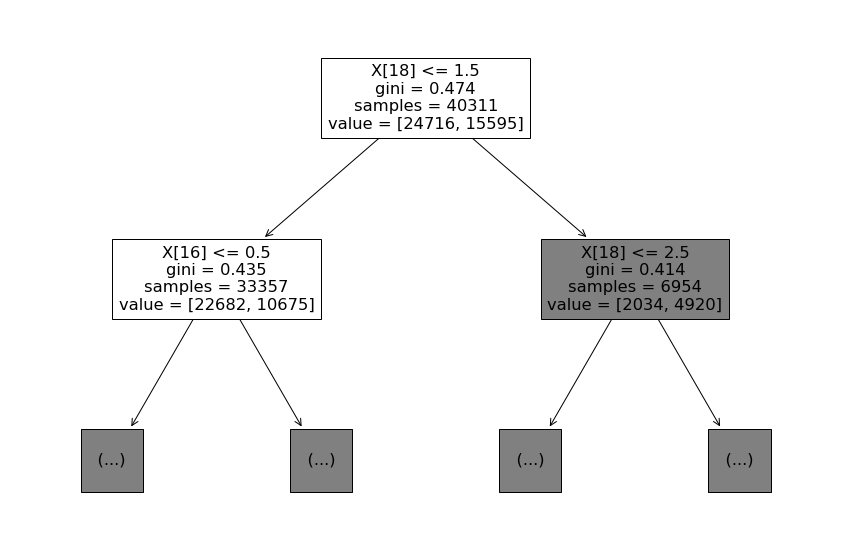

In [44]:
f, ax = plt.subplots(figsize=(15, 10))
plot_tree(tuned_tree, ax=ax, max_depth = 1);

In [ ]:
tuned_tree.classes_

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
X_test_imputed = pd.read_csv('X_test_imputed.csv', index_col=0)

In [ ]:
X_train_imputed = pd.read_csv('X_train_imputed.csv', index_col=0)

In [ ]:
X_train_imputed.rename(columns={'0': 'funder', '1': 'installer', '2': 'wpt_name', '3': 'basin', '4': 'subvillage',
                                  '5': 'region', '6': 'region_code', '7': 'district_code', '8': 'lga', '9': 'ward',
                                  '10': 'public_meeting', '11': 'scheme_management', '12': 'permit',
                                  '13': 'extraction_type_class', '14': 'management', '15': 'management_group', '16': 
                                  'payment', '17': 'quality_group', '18': 'quantity', '19': 'source', '20': 'source_type',
                                  '21': 'source_class', '22': 'waterpoint_type', '23': 'waterpoint_type_group', '24': 
                                  'date_recorded', '25': 'gps_height', '26': 'longitude', '27': 'latitude', '28': 'population',
                                  '29': 'construction_year'}, inplace=True)

In [ ]:
X_test_imputed.rename(columns={'0': 'funder', '1': 'installer', '2': 'wpt_name', '3': 'basin', '4': 'subvillage',
                                  '5': 'region', '6': 'region_code', '7': 'district_code', '8': 'lga', '9': 'ward',
                                  '10': 'public_meeting', '11': 'scheme_management', '12': 'permit',
                                  '13': 'extraction_type_class', '14': 'management', '15': 'management_group', '16': 
                                  'payment', '17': 'quality_group', '18': 'quantity', '19': 'source', '20': 'source_type',
                                  '21': 'source_class', '22': 'waterpoint_type', '23': 'waterpoint_type_group', '24': 
                                  'date_recorded', '25': 'gps_height', '26': 'longitude', '27': 'latitude', '28': 'population',
                                  '29': 'construction_year'}, inplace=True)

In [ ]:
def revert_back_to_strings(df, columns):
    #Creates a copy of the DataFrame so it isn't overwriting the original
    df_copy = df.copy()
    
    #looping through all columns given and changes the number back to the string it represents based off a dictionary zipped
    #from one list of the .value_counts() from df_small_small and another list that creates an index of the first
    for col in columns:
        column_vc = list(df_small_small[col].value_counts().index)
        column_rank = list(range(len(column_vc)))
    
        column_vc_rank = dict(zip(column_rank, column_vc))
    
        df_copy[col] = df_copy[col].replace(column_vc_rank)
    
    return df_copy

In [ ]:
#Creating a list of all column names in X_train_imputed
revert_columns = list(X_train_imputed.columns)
#Only taking the categorical columns from that list
revert_columns = revert_columns[:24]

In [ ]:
X_train_imputed = revert_back_to_strings(X_train_imputed, revert_columns)
X_train_imputed

In [ ]:
X_test_imputed = revert_back_to_strings(X_test_imputed, revert_columns)
X_test_imputed

In [ ]:
X_train_imputed.drop()
X_test_imputed


In [ ]:
precision_score(y_train, tuned_tree.predict(X_train_imputed), pos_label=0)